In [2]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
%matplotlib inline

In [3]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [4]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel
print('M:',M,'\t','n:',n_channel)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

M: 16 	 n: 1


In [5]:
#generating data of size N
N = 16000
label = np.random.randint(M,size=N)

In [6]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [7]:
# checking data shape
data = np.array(data)
print (data.shape)

(16000, 16)


In [8]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [9]:
# Average Power Normalization
def avg_power_norm(x):
    P_avg = 0.04
    beta = K.sqrt(K.sum(K.square(x)))
    return x / beta

In [10]:
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)
encoded3 = Lambda(lambda x: 2*K.l2_normalize(x,axis=-1))(encoded2)

# Gaussian Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel1 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

# Reciever Layer
decoded = Dense(M, activation='relu')(channel1)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
sgd = SGD(lr=0.02)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

W0709 16:37:03.305351 140364529686336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 16:37:03.307456 140364529686336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 16:37:03.329149 140364529686336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 16:37:03.492649 140364529686336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0709 16:37:03.542380 

In [11]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
__________

In [12]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=64)

W0709 16:37:03.876514 140364529686336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
16000/16000 [==============================] - 6s 358us/step - loss: 0.9519
Epoch 2/50
16000/16000 [==============================] - 2s 136us/step - loss: 0.4448
Epoch 3/50
16000/16000 [==============================] - 2s 134us/step - loss: 0.3935
Epoch 4/50
16000/16000 [==============================] - 2s 131us/step - loss: 0.3794
Epoch 5/50
16000/16000 [==============================] - 2s 141us/step - loss: 0.3936
Epoch 6/50
16000/16000 [==============================] - 2s 137us/step - loss: 0.3741
Epoch 7/50
16000/16000 [==============================] - 2s 134us/step - loss: 0.3440
Epoch 8/50
16000/16000 [==============================] - 2s 140us/step - loss: 0.3492
Epoch 9/50
16000/16000 [==============================] - 2s 139us/step - loss: 0.3287
Epoch 10/50
16000/16000 [==============================] - 2s 133us/step - loss: 0.3580
Epoch 11/50
16000/16000 [==============================] - 2s 137us/step - loss: 0.3329
Epoch 12/50
16000/16000 [================

In [13]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

In [14]:
# making channel from full autoencoder
channel_input = Input(shape=(2*n_channel,))

chan = autoencoder.layers[-3](channel_input)
channel_layer = Model(channel_input,chan)

In [15]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [16]:
# generating data for checking BER
N = 100000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [23]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = 1.5/2*np.array(scatter_plot)
print (scatter_plot.shape)

(16, 1, 2)


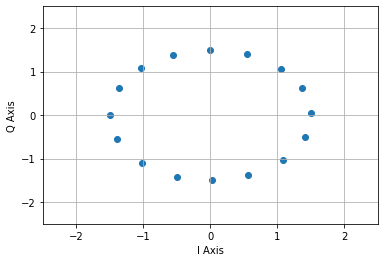

In [26]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

(16, 1, 2)


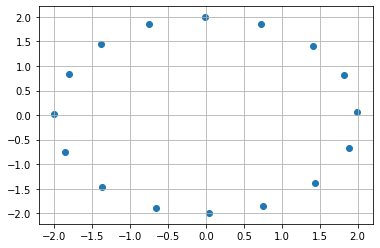

In [27]:
# for plotting learned consteallation diagram after gaussian channel

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(channel_layer.predict(encoder.predict(np.expand_dims(temp,axis=0))))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

In [20]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(np.arange(0,20+1,2))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std*np.random.randn(nn,2*n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal+noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: 0 BER: 0.28626
SNR: 2 BER: 0.18528
SNR: 4 BER: 0.10567
SNR: 6 BER: 0.04923
SNR: 8 BER: 0.01931
SNR: 10 BER: 0.00533
SNR: 12 BER: 0.00105
SNR: 14 BER: 0.00018
SNR: 16 BER: 0.0
SNR: 18 BER: 0.0
SNR: 20 BER: 0.0


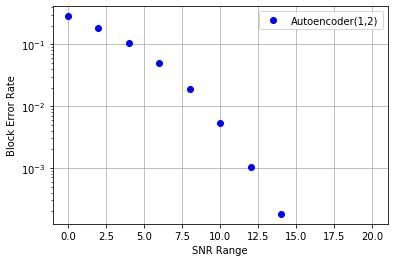

In [21]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(1,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()